In [ ]:
import pickle
ppg = pickle.load(open('../data/ppg2122sep.p','rb'))

In [ ]:
import matplotlib.pyplot as plt
ppg = ppg.sort_values('timestamp').reset_index(drop=True)

In [ ]:
# plt.plot(ppg)
ppg['hour'] = ppg['localtime'].apply(lambda a:a.hour)
from datetime import datetime
ppg['time'] = ppg['localtime'].apply(lambda a:a.timestamp())


In [ ]:
ppg = ppg[(ppg.day=='20200922')&(ppg['hour']>=0)&(ppg['hour']<=17)]
# ppg.head()

In [ ]:
import pandas as pd
df_col = [df.sort_values('time').reset_index(drop=True) for i,df in ppg.groupby(pd.Grouper(key='timestamp',freq='60S')) if df.shape[0]>0]

In [ ]:
hour_col = [np.median(a['hour'].values) for a in df_col]

In [ ]:
from scipy.stats import iqr
X = []
for df in df_col:
    df_small_col = [a for i,a in df.groupby(pd.Grouper(key='timestamp',freq='5S')) if a.shape[0]>0]
    std_col = [np.sqrt(a['x'].std()**2+a['y'].std()**2+a['z'].std()**2) for a in df_small_col]
    X.append(iqr(std_col))

In [ ]:
hour_col = np.array(hour_col)
hour_col[hour_col<14] = 0
hour_col[hour_col>0] = 1


In [ ]:
df = pd.DataFrame({'x':hour_col,'acl_std':X})

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
sns.boxplot(x='x',y='acl_std',data=df)
plt.xticks([0,1],['Not Worn','Worn'])
plt.xlabel('')
plt.ylabel('80th percentile of ACL std\n in a minute')
plt.savefig('../images/wornvsnotworn.png')
plt.show()

In [ ]:
sampling_freq = [1/np.mean(np.diff(a['time'].values)) for a in df_col]

In [ ]:
import numpy as np
length_col = np.array([a.shape[0] for a in df_col if a.shape[0]>0])

In [ ]:
len(df_col)

In [ ]:
plt.figure()
plt.hist(length_col)
plt.title('HIstogram of PPG Sampling Frequency\n(calculated for each minute)')
plt.xlabel('Hz')
# plt.savefig('../images/ppg_sampling.png')
plt.show()

In [ ]:
plt.rcParams.update({'font.size':40})
plt.figure(figsize=(30,20))
# plt.plot(ppg['localtime'],ppg['x'],'*',label='ACL-X')
# plt.plot(ppg['localtime'],ppg['y'],'o',label='ACL-Y')
# plt.plot(ppg['localtime'],ppg['z'],'s',label='ACL-Z')
plt.plot(ppg['localtime'],ppg['ppg1'],'s',label='PPG')
# plt.ylim([-20,20])
plt.legend()
plt.savefig('../images/ppg_data.png')
plt.show()

In [ ]:
import zipfile
with zipfile.ZipFile('../data/ppg_data_6th_oct.zip', 'r') as zip_ref:
    zip_ref.extractall('../data/')

In [1]:
import os
filepath = '../data/ppg_data_6th_oct/'
import gzip
import pandas as pd
import msgpack
import argparse

def msgpack_to_pandas(input_data: object) -> pd.DataFrame:
    """
    Convert msgpack binary file into pandas dataframe
    Args:
        input_data (msgpack): msgpack data file
    Returns:
        dataframe: pandas dataframe
    """
    data = []

    unpacker = msgpack.Unpacker(input_data, use_list=False, raw=False)
    for unpacked in unpacker:
        data.append(list(unpacked))

    header = data[0]
    data = data[1:]

    if data is None:
        return None
    else:
        df = pd.DataFrame(data, columns=header)
        df.columns = df.columns.str.lower()
        df.timestamp = pd.to_datetime(df['timestamp'], unit='us')
        df.timestamp = df.timestamp.dt.tz_localize('UTC')
        df.localtime = pd.to_datetime(df['localtime'], unit='us')
        df.localtime = df.localtime.dt.tz_localize('UTC')
        return df

In [2]:
ppg = []
acl = []
onbody = []
for a in os.listdir(filepath):
    if a.split('_')[0]=='ppg':
        try:
            with gzip.open(filepath+'/'+a, 'rb') as input_data:
                ppg.append(msgpack_to_pandas(input_data))
        except Exception as e:
            print(e)
    if a.split('_')[0]=='accel':
        try:
            with gzip.open(filepath+'/'+a, 'rb') as input_data:
                acl.append(msgpack_to_pandas(input_data))
        except Exception as e:
            print(e)
    if a.split('_')[0]=='onBody':
        try:
            with gzip.open(filepath+'/'+a, 'rb') as input_data:
                onbody.append(msgpack_to_pandas(input_data))
        except Exception as e:
            print(e)

In [3]:
indicator_data = pd.concat(onbody)

In [4]:
ppg_data = pd.concat(ppg)

In [5]:
accel_data = pd.concat(acl)

In [6]:
ppg_data = ppg_data.sort_values('localtime').reset_index(drop=True)

In [7]:
from datetime import datetime

/cerebralcortex/kessel_jupyter_virtualenv/cc3_high_performance/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


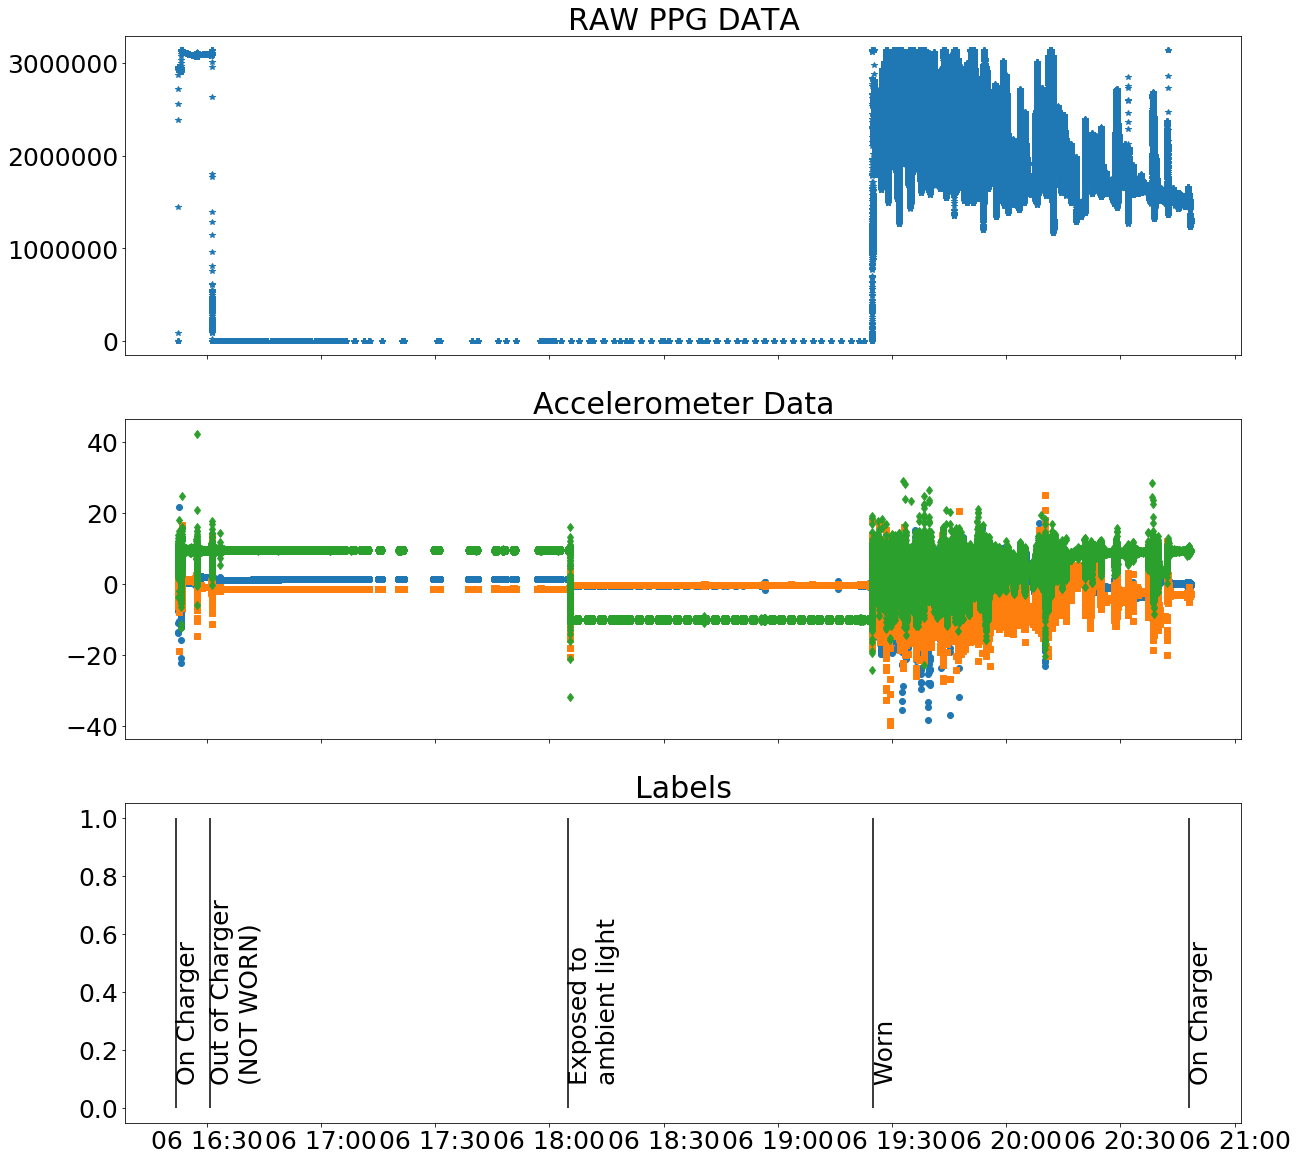

In [8]:
from scipy import signal
import numpy as np
def filter_data(X,
                Fs=100,
                low_cutoff=.4,
                high_cutoff=3.0,
                filter_order=65):
    """
    Bandpass Filter of single channel

    :param X: input data
    :param Fs: sampling freq.
    :param low_cutoff: low passband
    :param high_cutoff: high passband
    :param filter_order: no of taps in FIR filter

    :return: filtered version of input data
    """
    X1 = X.reshape(-1,1)
    X1 = signal.detrend(X1,axis=0,type='constant')
    b = signal.firls(filter_order,np.array([0,low_cutoff-.1, low_cutoff, high_cutoff ,high_cutoff+.5,Fs/2]),np.array([0, 0 ,1 ,1 ,0, 0]),
                     np.array([100*0.02,0.02,0.02]),fs=Fs)
    X2 = signal.convolve(X1.reshape(-1),b,mode='same')
    return X2

from scipy.stats.mstats import winsorize
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size':25})
fig,ax = plt.subplots(3,1,figsize=(20,20),sharex=True)
k = 0
ax[k].plot(ppg_data['localtime'],winsorize(ppg_data['ppg1'],limits=[.05,.02]),'*')
ax[k].set_title('RAW PPG DATA')
# k+=1
# ax[k].plot(ppg_data['localtime'],winsorize(filter_data(ppg_data['ppg1'].values),limits=[.01,.01]),'^')
# ax[k].set_title('Bandpass Filtered PPG DATA')
k+=1
ax[k].plot(accel_data['localtime'],accel_data['x'],'o')
ax[k].plot(accel_data['localtime'],accel_data['y'],'s')
ax[k].plot(accel_data['localtime'],accel_data['z'],'d')
ax[k].set_title('Accelerometer Data')
x_time = [datetime(2020, 10, 6,16,22,0),
          datetime(2020, 10, 6,16,31,0),
          datetime(2020, 10, 6,18,5,0),
          datetime(2020, 10, 6,19,25,0),
          datetime(2020, 10, 6,20,48,0)]
y_time = ['On Charger',
         'Out of Charger \n(NOT WORN)',
         'Exposed to \nambient light',
         'Worn',
         'On Charger']
k+=1
ax[k].vlines(x_time,0,1)
for i,x in enumerate(x_time):
    ax[k].text(x,.1,y_time[i],rotation=90)
ax[k].set_title('Labels')
plt.savefig('../data/pictures/data.png')
plt.show()

In [55]:
# ppg_data['hour'] = ppg_data['localtime'].apply(lambda a:a.hour)
# ppg_data = ppg_data[(ppg_data.hour>=15)&(ppg_data.hour<=19)]
# accel_data['hour'] = accel_data['localtime'].apply(lambda a:a.hour)
# accel_data = accel_data[(accel_data.hour>=15)&(accel_data.hour<=19)]
ppg_data['time'] = ppg_data['timestamp'].apply(lambda a:a.timestamp())
accel_data['time'] = accel_data['timestamp'].apply(lambda a:a.timestamp())

In [56]:
def get_ppg_60_sec_windows(ppg_data):
    ppg_windows = [df for i,df in ppg_data.groupby(pd.Grouper(key='localtime',freq='60S')) if df.shape[0]>10]
    times = [a['time'].values[0] for a in ppg_windows]
    localtimes = [a['localtime'].values[0] for a in ppg_windows]
    ppg_minute_data = pd.DataFrame({'window':ppg_windows,'time':times,'localtime':localtimes})
    return ppg_minute_data.sort_values('time').reset_index(drop=True)

In [57]:
ppg_minute_data = get_ppg_60_sec_windows(ppg_data)
accel_minute_data = get_ppg_60_sec_windows(accel_data)

In [58]:
start_ts = ppg_minute_data['time'].min()

In [59]:
from datetime import timedelta
y_std = []
y_localtime = []
y_time = []
k = 0
start_ts = accel_minute_data['time'].min()
for t in np.arange(accel_minute_data['time'].min(),accel_minute_data['time'].max()+60,60):
    index = np.argmin(np.abs(accel_minute_data['time'].values-t))
    if np.abs(t-accel_minute_data['time'].values[index])<=65:
        minute_df = accel_minute_data['window'].loc[index]
        accel_5sec_data = [df for i,df in minute_df.groupby(pd.Grouper(key='localtime',freq='5S')) if df.shape[0]>10]
        accel_stds = [np.sqrt(df['x'].std()**2+df['y'].std()**2+df['z'].std()**2) for df in accel_5sec_data]
        y_std.append(np.percentile(accel_stds,25))
        y_localtime.append(minute_df['localtime'].min())
        y_time.append(t)
#         print(index,df.shape)
    else:
        y_std.append(y_std[-1])
        y_localtime.append(y_localtime[-1]+timedelta(seconds=60))
        y_time.append(t)
#         print(index)

In [60]:
y_worn = [-1]*3
for k in range(2,len(y_std)-1,1):
    temp = np.array(y_std[k-2:k+1])
    if len(temp[temp<=0.018])>=2:
        y_worn.append(-1)
    else:
        y_worn.append(1)

In [86]:
from scipy.stats.mstats import winsorize
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size':25})
fig,ax = plt.subplots(3,1,figsize=(20,20),sharex=True)
k = 0
ax[k].plot(accel_data['localtime'],accel_data['x'],'o')
ax[k].plot(accel_data['localtime'],accel_data['y'],'s')
ax[k].plot(accel_data['localtime'],accel_data['z'],'d')
ax[k].set_title('Accelerometer Data')
x_time = [datetime(2020, 10, 6,16,22,0),
          datetime(2020, 10, 6,16,31,0),
          datetime(2020, 10, 6,18,5,0),
          datetime(2020, 10, 6,19,25,0),
          datetime(2020, 10, 6,20,48,0)]
y_time = ['On Charger',
         'Out of Charger \n(NOT WORN)',
         'Exposed to \nambient light',
         'Worn',
         'On Charger']
k+=1
ax[k].vlines(x_time,0,3)
for i,x in enumerate(x_time):
    ax[k].text(x,.1,y_time[i],rotation=90)
ax[k].set_title('Labels')
k+=1
ax[k].plot(y_localtime,y_std,'b*',label='25th Percentile ACL STD')
ax[k].plot(y_localtime,y_worn,'r*--',label='Predicted Worn vs Not Worn in Next Minute')
ax[k].legend()

plt.savefig('../data/pictures/data_std.png')
plt.show()

In [86]:
ppg_minute_data['worn'] = 0
k = 0
while k<len(y_worn):
    if y_worn[k]>-1:
        start_ts = y_time[k]
        i = k
        while i<len(y_worn) and y_worn[i]>-1:
            i+=1
        end_ts = y_time[i-1]
        print(end_ts-start_ts)
        k = i+1
        ppg_minute_data['worn'][(ppg_minute_data['time']>=start_ts)&(ppg_minute_data['time']<=end_ts)] = 1
    k+=1
#         index = np.argmin(np.abs(ppg_minute_data['time'].values-a))
#         print(index)
# ppg_minute_data.head()

120.0
4980.0


/cerebralcortex/kessel_jupyter_virtualenv/cc3_high_performance/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


In [106]:
from scipy import signal
import numpy as np

from scipy.stats import skew,kurtosis
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from scipy import signal
from pyspark.sql.functions import pandas_udf, PandasUDFType
from pyspark.sql.types import StructField, StructType, DoubleType, StringType, TimestampType, IntegerType, ArrayType
import numpy as np
import pandas as pd
from cerebralcortex.core.datatypes import DataStream
from cerebralcortex.core.metadata_manager.stream.metadata import Metadata, DataDescriptor, \
    ModuleMetadata

### Peak Detection codes ##

def _datacheck_peakdetect(x_axis, y_axis):
    """
    check data for peak detection

    :param x_axis: time
    :param y_axis: values
    :return: same as input data
    """
    if x_axis is None:
        x_axis = range(len(y_axis))

    if len(y_axis) != len(x_axis):
        raise ValueError("Input vectors y_axis and x_axis must have same length")

    #needs to be a numpy array
    y_axis = np.array(y_axis)
    x_axis = np.array(x_axis)
    return x_axis, y_axis


def peakdetect(y_axis, x_axis = None, lookahead = 200, delta=0):
    """

    :param y_axis: values
    :param x_axis: time
    :param lookahead: steps ahead to look for
    :param delta:
    :return: peak locations

    """
    max_peaks = []
    min_peaks = []
    dump = []   #Used to pop the first hit

    # check input data
    x_axis, y_axis = _datacheck_peakdetect(x_axis, y_axis)
    # store data length for later use
    length = len(y_axis)


    #perform some checks
    if lookahead < 1:
        raise ValueError("Lookahead must be '1' or above in value")
    if not (np.isscalar(delta) and delta >= 0):
        raise ValueError("delta must be a positive number")

    #maxima and minima candidates are temporarily stored in
    #mx and mn respectively
    mn, mx = np.Inf, -np.Inf

    #Only detect peak if there is 'lookahead' amount of points after it
    for index, (x, y) in enumerate(zip(x_axis[:-lookahead],
                                       y_axis[:-lookahead])):
        if y > mx:
            mx = y
            mxpos = x
        if y < mn:
            mn = y
            mnpos = x

        ####look for max####
        if y < mx-delta and mx != np.Inf:
            #Maxima peak candidate found
            #look ahead in signal to ensure that this is a peak and not jitter
            if y_axis[index:index+lookahead].max() < mx:
                max_peaks.append([mxpos, mx])
                dump.append(True)
                #set algorithm to only find minima now
                mx = np.Inf
                mn = np.Inf
                if index+lookahead >= length:
                    #end is within lookahead no more peaks can be found
                    break
                continue

        ####look for min####
        if y > mn+delta and mn != -np.Inf:
            #Minima peak candidate found
            #look ahead in signal to ensure that this is a peak and not jitter
            if y_axis[index:index+lookahead].min() > mn:
                min_peaks.append([mnpos, mn])
                dump.append(False)
                #set algorithm to only find maxima now
                mn = -np.Inf
                mx = -np.Inf
                if index+lookahead >= length:
                    #end is within lookahead no more peaks can be found
                    break

    #Remove the false hit on the first value of the y_axis
    try:
        if dump[0]:
            max_peaks.pop(0)
        else:
            min_peaks.pop(0)
        del dump
    except IndexError:
        pass

    return [max_peaks, min_peaks]

### CQP quality features and heart rate estimation

def get_predict_prob(window):
    """
    Get CQP quality features
    :param window: Numpy array of PPG data
    :return: quality features
    """
    no_channels = window.shape[1]
    window[:,:] = signal.detrend(RobustScaler().fit_transform(window),axis=0)
    f,pxx = signal.welch(window,fs=100,nperseg=len(window),nfft=10000,axis=0)
    pxx = np.abs(pxx)
    pxx = MinMaxScaler().fit_transform(pxx)
    skews = skew(window,axis=0).reshape(no_channels,1)
    kurs = kurtosis(window,axis=0).reshape(no_channels,1)
    iqrs = np.std(window,axis=0).reshape(no_channels,1)
    rps = np.divide(np.trapz(pxx[np.where((f>=.8)&(f<=2.5))[0]],axis=0),np.trapz(pxx,axis=0)).reshape(no_channels,1)
    features = np.concatenate([skews,kurs,rps,iqrs],axis=1)
    return features

def get_rr_value(values,fs=100):
    """
    Get Mean RR interval

    :param values: single channel ppg data
    :param fs: sampling frequency
    :return: Mean RR interval Information
    """
    try:
        f, pxx = signal.welch(values,fs=fs,nperseg=values.shape[0],nfft=10000,axis=0)
        f = f.reshape(-1)
        pxx = pxx.reshape(-1,1)
        peakind =  peakdetect(pxx[:,0],lookahead=2)
        x = []
        y = []
        for a in peakind[0]:
            x.append(a[0])
            y.append(a[1])
        x = np.array(x)
        x = x[f[x]>.8]
        x = x[f[x]<2.5]
        f = f[x]
        pxx = pxx[x,0]
        return 60000/(60*f[np.argmax(pxx)])
    except Exception as e:
        return 0


def filter_data(X,
                Fs=100,
                low_cutoff=.4,
                high_cutoff=3.0,
                filter_order=65):
    """
    Bandpass Filter of single channel

    :param X: input data
    :param Fs: sampling freq.
    :param low_cutoff: low passband
    :param high_cutoff: high passband
    :param filter_order: no of taps in FIR filter

    :return: filtered version of input data
    """
    X1 = X.reshape(-1,1)
    X1 = signal.detrend(X1,axis=0,type='constant')
    b = signal.firls(filter_order,np.array([0,low_cutoff-.1, low_cutoff, high_cutoff ,high_cutoff+.5,Fs/2]),np.array([0, 0 ,1 ,1 ,0, 0]),
                     np.array([100*0.02,0.02,0.02]),fs=Fs)
    X2 = signal.convolve(X1.reshape(-1),b,mode='same')
    return X2
from scipy.stats import iqr
ppg_clean_data = []
ppg_iqrs = []
yhr = []
yhr_localtime = []
for i,row in ppg_minute_data.iterrows():
    if row['worn']==1 and row['window'].shape[0]>60*100*.5:
        df = row['window']
        df['ppg_filtered'] = filter_data(df['ppg1'].values)
        if iqr(df['ppg_filtered'].values)<5000:
            continue
        ppg_5sec_data = [d for i,d in df.groupby(pd.Grouper(key='localtime',freq='5S')) if d.shape[0]>5*100*.8]
        if len(ppg_5sec_data)==0:
            continue
        hrs = []
        for df1 in ppg_5sec_data:
            hrs.append(get_rr_value(df1['ppg_filtered'],fs=100))
        yhr.append(np.median(hrs))
        yhr_localtime.append(row['localtime'])
#         ppg_iqrs.append(iqr(df['ppg_filtered']))
#         plt.figure(figsize=(20,10))
#         plt.plot(df['localtime'],winsorize(df['ppg_filtered'],limits=[0.01,0.02]))
#         plt.show()

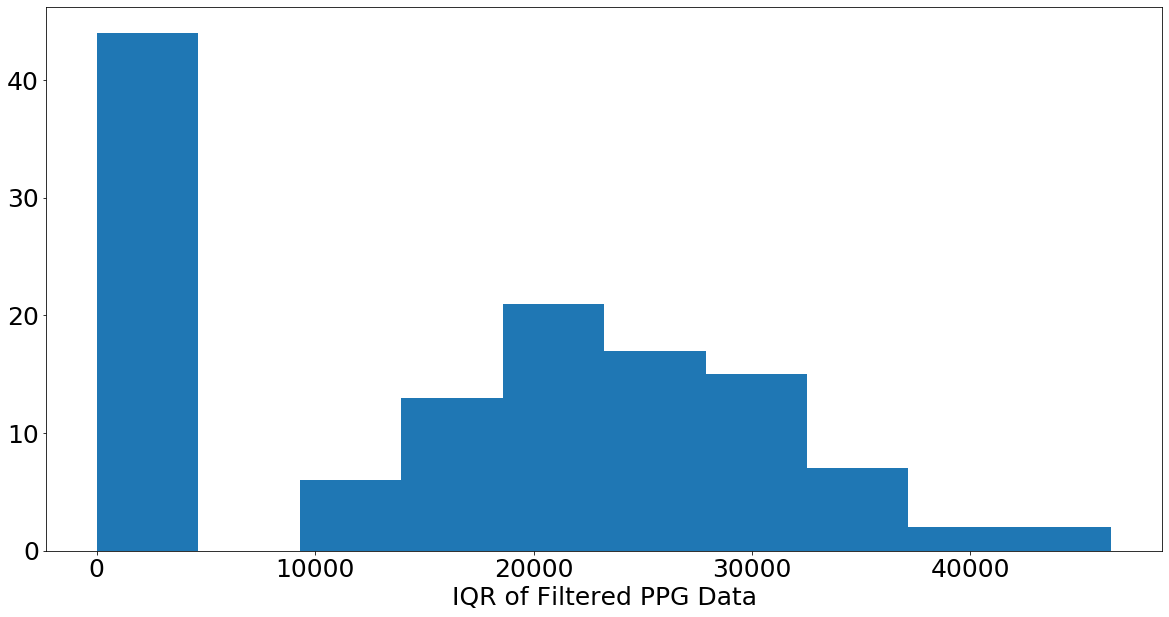

In [101]:
plt.figure(figsize=(20,10))
plt.hist(ppg_iqrs)
plt.xlabel('IQR of Filtered PPG Data')
plt.savefig('../data/pictures/iqr.png')
plt.show()

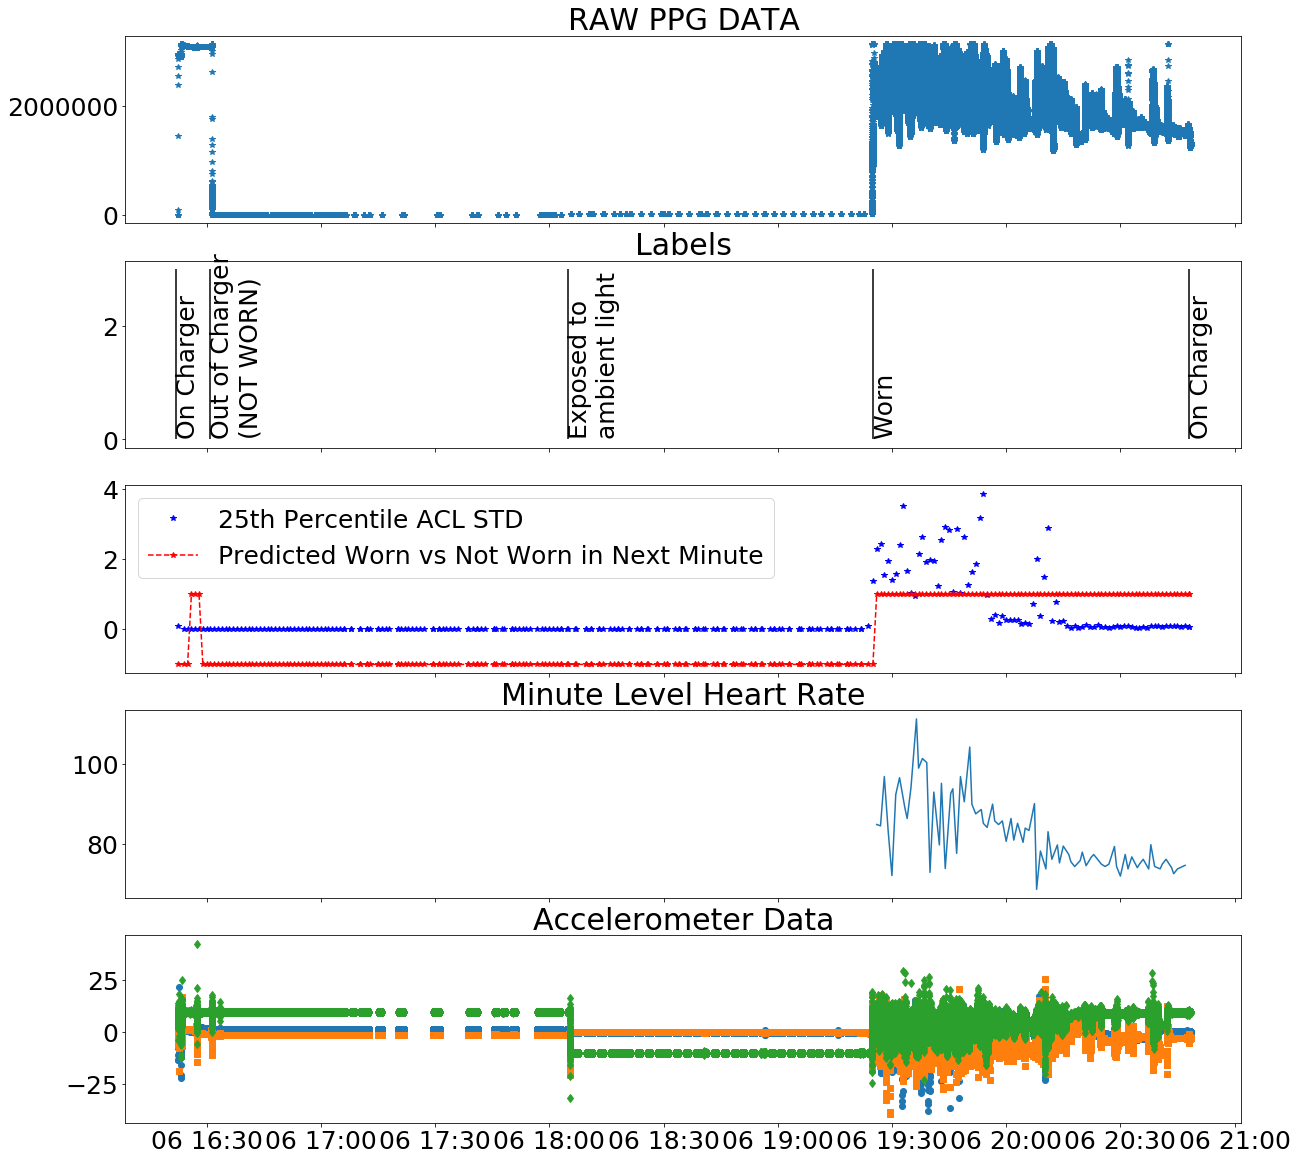

In [115]:
from scipy.stats.mstats import winsorize
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size':25})
fig,ax = plt.subplots(5,1,figsize=(20,20),sharex=True)
k = 0
ax[k].plot(ppg_data['localtime'],winsorize(ppg_data['ppg1'],limits=[.05,.02]),'*')
ax[k].set_title('RAW PPG DATA')
x_time = [datetime(2020, 10, 6,16,22,0),
          datetime(2020, 10, 6,16,31,0),
          datetime(2020, 10, 6,18,5,0),
          datetime(2020, 10, 6,19,25,0),
          datetime(2020, 10, 6,20,48,0)]
y_time = ['On Charger',
         'Out of Charger \n(NOT WORN)',
         'Exposed to \nambient light',
         'Worn',
         'On Charger']
k+=1
ax[k].vlines(x_time,0,3)
for i,x in enumerate(x_time):
    ax[k].text(x,.1,y_time[i],rotation=90)
ax[k].set_title('Labels')
k+=1
ax[k].plot(y_localtime,y_std,'b*',label='25th Percentile ACL STD')
ax[k].plot(y_localtime,y_worn,'r*--',label='Predicted Worn vs Not Worn in Next Minute')
ax[k].legend()
k+=1
ax[k].plot(yhr_localtime,60000/np.array(yhr))
ax[k].set_title('Minute Level Heart Rate')
k+=1
ax[k].plot(accel_data['localtime'],accel_data['x'],'o')
ax[k].plot(accel_data['localtime'],accel_data['y'],'s')
ax[k].plot(accel_data['localtime'],accel_data['z'],'d')
ax[k].set_title('Accelerometer Data')
# plt.xlim([yhr_localtime[0],yhr_localtime[-1]])
plt.savefig('../data/pictures/data_hr.png')

plt.show()

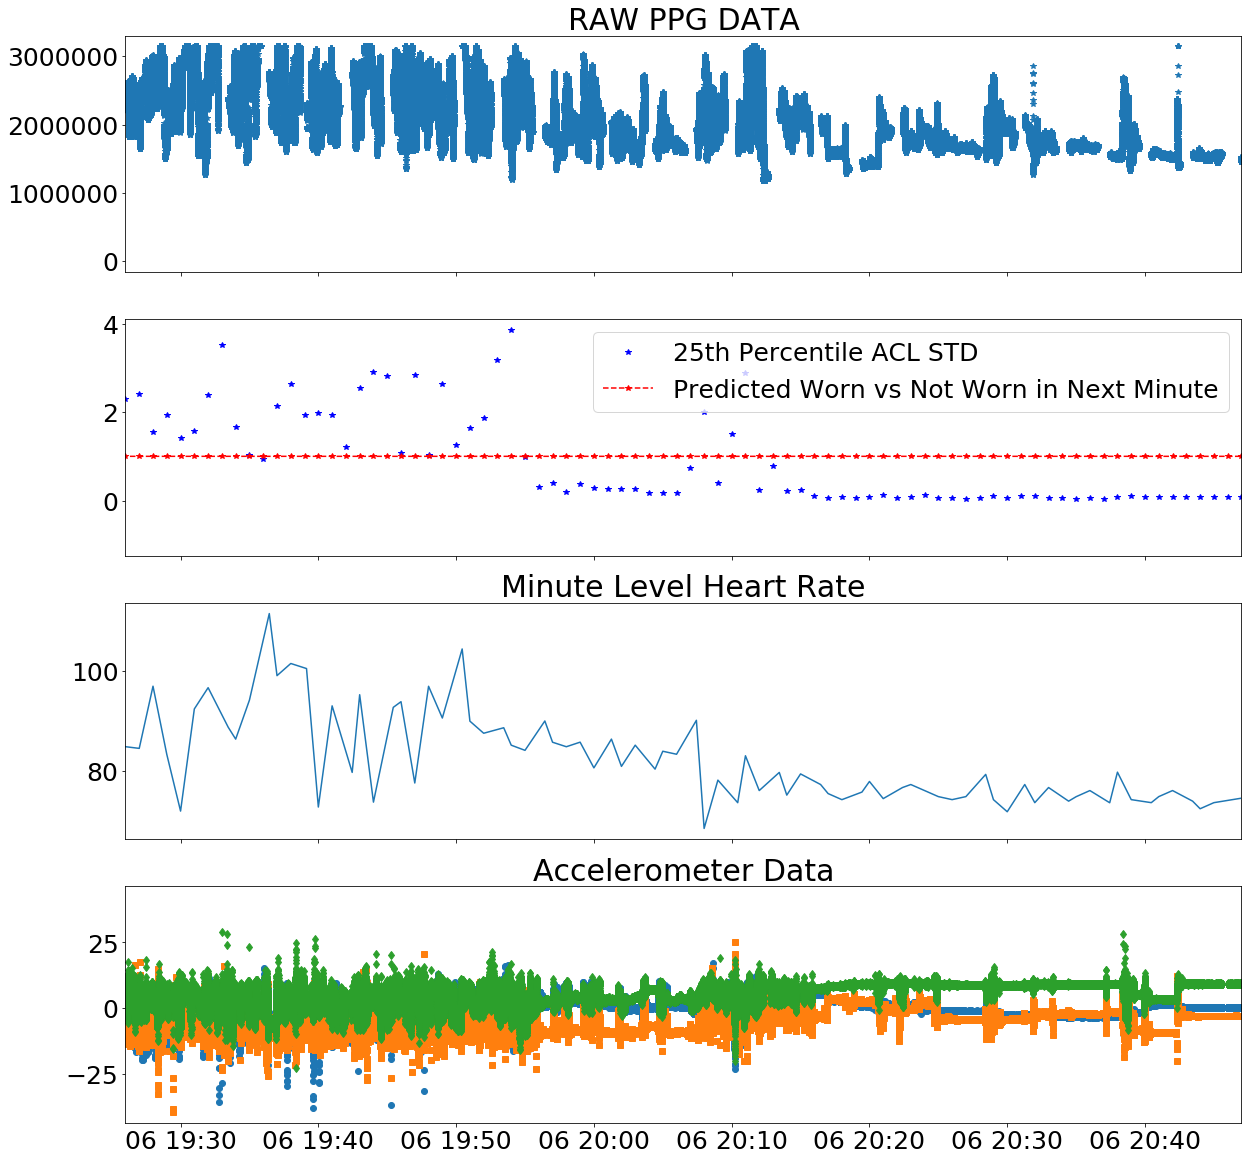

In [117]:
from scipy.stats.mstats import winsorize
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size':25})
fig,ax = plt.subplots(4,1,figsize=(20,20),sharex=True)
k = 0
ax[k].plot(ppg_data['localtime'],winsorize(ppg_data['ppg1'],limits=[.05,.02]),'*')
ax[k].set_title('RAW PPG DATA')
k+=1
ax[k].plot(y_localtime,y_std,'b*',label='25th Percentile ACL STD')
ax[k].plot(y_localtime,y_worn,'r*--',label='Predicted Worn vs Not Worn in Next Minute')
ax[k].legend()
k+=1
ax[k].plot(yhr_localtime,60000/np.array(yhr))
ax[k].set_title('Minute Level Heart Rate')
k+=1
ax[k].plot(accel_data['localtime'],accel_data['x'],'o')
ax[k].plot(accel_data['localtime'],accel_data['y'],'s')
ax[k].plot(accel_data['localtime'],accel_data['z'],'d')
ax[k].set_title('Accelerometer Data')
plt.xlim([yhr_localtime[0],yhr_localtime[-1]])
plt.savefig('../data/pictures/data_hr_good.png')
plt.show()

In [ ]:
len(y_std),len()

In [ ]:
import numpy as np
start_ts = np.max([ppg_data['time'].min(),accel_data['time'].min()])
end_ts = np.min([ppg_data['time'].max(),accel_data['time'].max()])

In [ ]:
accel_data.head()

In [ ]:
count = 0
import matplotlib.pyplot as plt
for t in np.arange(start_ts,end_ts,180):
    ppg_window = ppg_data[(ppg_data['time']>=t)&(ppg_data['time']<t+60)]
    accel_window = accel_data[(accel_data['time']>=t)&(accel_data['time']<t+60)]
    if ppg_window.shape[0]>100*60*.5:
        for t1 in np.arange(t,t+60,1):
            ppg_5_sec =  ppg_window[(ppg_window['time']>=t1)&(ppg_window['time']<t1+5)]
            accel_5_sec = accel_window[(accel_window['time']>=t1)&(accel_window['time']<t1+5)]
            plt.figure(figsize=(10,10))
#             plt.plot(ppg_5_sec['localtime'],ppg_5_sec['ppg1']/ppg_5_sec['ppg1'].max())
            plt.plot(accel_5_sec['localtime'],accel_5_sec['x'])
            plt.plot(accel_5_sec['localtime'],accel_5_sec['y'])
            plt.plot(accel_5_sec['localtime'],accel_5_sec['z'])
            plt.show()
#     print(ppg_window.shape,accel_window.shape)

In [ ]:
accel_data.localtime.min()

In [ ]:
data.shape

In [ ]:
import matplotlib.pyplot as plt
data = data.sort_values('timestamp').reset_index(drop=True)

In [ ]:
data['hour'] = data['localtime'].apply(lambda a:a.hour)

data = data[(data.hour>=15)&(data.hour<=19)]

In [ ]:
plt.figure(figsize=(20,20))
plt.plot(data['localtime'],data['ppg1'])
# plt.ylim([np.percentile(data['ppg1'],1),np.percentile(data['ppg1'],95)])
plt.show()

In [ ]:
data.localtime.max(),data.localtime.min()

In [ ]:
import pandas as pd
data['time'] = data['localtime'].apply(lambda a:a.timestamp())
df_col = [df.sort_values('time').reset_index(drop=True) for i,df in data.groupby(pd.Grouper(key='timestamp',freq='60S')) if df.shape[0]>0]

In [ ]:
sampling_freq = [1/np.median(np.diff(a['time'].values)) for a in df_col]

In [ ]:
plt.hist(sampling_freq)

In [ ]:
import numpy as np
length_col = np.array([a.shape[0] for a in df_col if a.shape[0]>0])

In [ ]:
plt.hist(length_col)